In [2]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.utils.class_weight import compute_class_weight
import numpy as np


2025-10-04 07:15:56.792421: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-04 07:15:57.131326: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:

# Path to your dataset
DATASET_PATH = "./dataset"

# Load training and validation datasets
train_ds = image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(224, 224),
    batch_size=BATCH_SIZE,
    label_mode="categorical"  # Ensures one-hot encoding
)

val_ds = image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(224, 224),
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

Found 39000 files belonging to 9 classes.
Using 31200 files for training.
Found 39000 files belonging to 9 classes.
Using 7800 files for validation.


In [6]:

NUM_CLASSES = 9
BATCH_SIZE = 8
LEARNING_RATE = 1e-4


In [ ]:
model = load_model("resnet50_cancer_model-version-1.keras")

ValueError: File not found: filepath=./models/resnet50_cancer_model-version-2.keras. Please ensure the file is an accessible `.keras` zip file.

In [10]:


# Load raw training dataset (no shuffle, no map, no prefetch)
raw_train_ds = image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(224, 224),
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

# Extract labels batch-by-batch (memory-safe)
class_indices = []
for _, label_batch in raw_train_ds:
    class_indices.extend(tf.argmax(label_batch, axis=1).numpy())

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(class_indices),
    y=class_indices
)

class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights_dict)


Found 39000 files belonging to 9 classes.
Using 31200 files for training.
Class weights: {0: 1.0846891948268669, 1: 1.0853683990816114, 2: 1.0949673615498, 3: 1.0766045548654244, 4: 1.082656672912763, 5: 1.0949673615498, 6: 1.1613623673925182, 7: 0.5726241603347649, 8: 1.1490443044967407}


2025-10-01 14:52:46.649940: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [11]:
for layer in model.layers[-20:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

# ✅ Recompile with lower learning rate
model.compile(
    optimizer=Adam(learning_rate=5e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [12]:
early_exit = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# ✅ Train
EPOCHS = 15  # Short fine-tuning phase

history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weights_dict,
    callbacks=[early_exit, lr_scheduler]
)


Epoch 1/15


I0000 00:00:1759330732.696081    1062 service.cc:145] XLA service 0x7ee408014400 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759330732.696579    1062 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-10-01 14:58:53.813412: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-01 14:58:57.285539: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
I0000 00:00:1759330738.847511    2552 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_9038', 528 bytes spill stores, 380 bytes spill loads

I0000 00:00:1759330756.801936    1062 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion_48', 444 bytes spill stores, 444 byt

3900/3900 ━━━━━━━━━━━━━━━━━━━━ 381s 86ms/step - accuracy: 0.9126 - loss: 0.4111 - val_accuracy: 0.9190 - val_loss: 0.3031 - learning_rate: 5.0000e-05
Epoch 2/15
3900/3900 ━━━━━━━━━━━━━━━━━━━━ 335s 86ms/step - accuracy: 0.9867 - loss: 0.0407 - val_accuracy: 0.9795 - val_loss: 0.0520 - learning_rate: 5.0000e-05
Epoch 3/15
3900/3900 ━━━━━━━━━━━━━━━━━━━━ 345s 88ms/step - accuracy: 0.9908 - loss: 0.0331 - val_accuracy: 0.9962 - val_loss: 0.0130 - learning_rate: 5.0000e-05
Epoch 4/15
3900/3900 ━━━━━━━━━━━━━━━━━━━━ 369s 94ms/step - accuracy: 0.9934 - loss: 0.0244 - val_accuracy: 0.9949 - val_loss: 0.0167 - learning_rate: 5.0000e-05
Epoch 5/15
3900/3900 ━━━━━━━━━━━━━━━━━━━━ 366s 94ms/step - accuracy: 0.9936 - loss: 0.0218 - val_accuracy: 0.9988 - val_loss: 0.0037 - learning_rate: 5.0000e-05
Epoch 6/15
3900/3900 ━━━━━━━━━━━━━━━━━━━━ 388s 99ms/step - accuracy: 0.9956 - loss: 0.0178 - val_accuracy: 0.9938 - val_loss: 0.0186 - learning_rate: 5.0000e-05
Epoch 7/15
3900/3900 ━━━━━━━━━━━━━━━━━━━━ 368

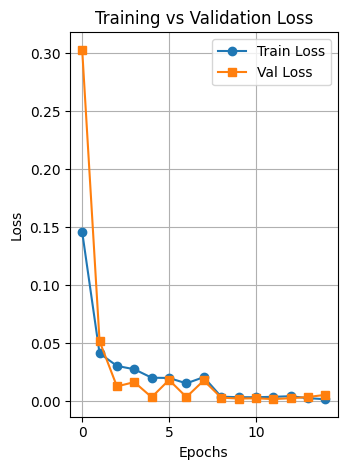

In [14]:
import matplotlib.pyplot as plt

# Extract metrics
acc = history_finetune.history['accuracy']
val_acc = history_finetune.history['val_accuracy']
loss = history_finetune.history['loss']
val_loss = history_finetune.history['val_loss']
epochs_range = range(len(acc))


# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Val Loss', marker='s')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


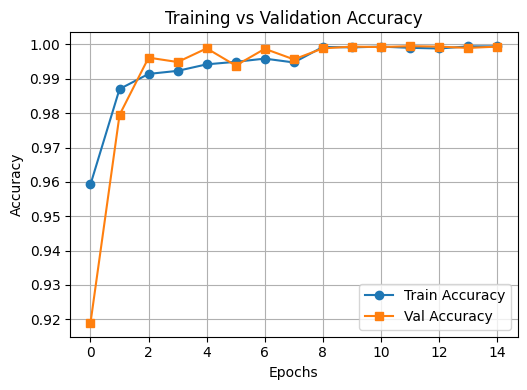

In [15]:
# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Val Accuracy', marker='s')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

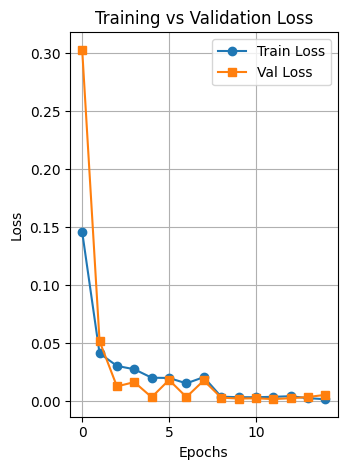

In [16]:
# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Val Loss', marker='s')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
model.save("./models/resnet50_cancer_model-finetuned-version-1.keras")

In [17]:
import pickle

# Create and save training history to a new file
with open("history_finetune.pkl", "wb") as f:
    pickle.dump(history_finetune.history, f)

print("✅ Training history saved to 'history_finetune.pkl'")


✅ Training history saved to 'history_finetune.pkl'
